In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#go into your Drive folders where your data is stored
cd drive/My\ Drive/Code/Visual_Question_Answering/

## Load the data

In [0]:
import pickle
from collections import deque
import numpy as np

file_name='./data/processed_data/questions-visual_features-train.txt'

with open(file_name, 'rb') as pickleFile:
  train_deque=pickle.load(pickleFile)

train_questions, train_images, train_answers = zip(*train_deque)

### CONVERT FROM TUPLE TO ARRAY
train_questions=np.array(train_questions)
train_visual_features=np.array(train_images)
train_answers=np.array(train_answers)

## Fit tokenizer

In [14]:
import pandas as pd

## read the csv files with the data

train_dir='./data/processed_data/DAQUAR_train_processed.csv'
test_dir='./data/processed_data/DAQUAR_test_processed.csv'

data_train=pd.read_csv(train_dir)
data_test=pd.read_csv(test_dir)

# Make sure that our version of tensorflow is not 2.0
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
from keras.preprocessing.text import Tokenizer

#create an instance of class Tokenizer
MAX_WORDS = 3000
tokenizer = Tokenizer(num_words = MAX_WORDS, split=' ')

#has to fit on questions and answers of the train dataset only
tokenizer.fit_on_texts(data_train['question'])
tokenizer.fit_on_texts(data_train['answer'])

1.15.0


In [0]:
import pickle

# saving
with open('./data/tokenizer/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('./data/tokenizer/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Model

In [0]:
import numpy as np

embedding_matrix=np.load('./data/embedding/glove_300d_embedding.npy')

In [0]:
from keras.models import Model
from keras.layers import LSTM, Bidirectional
from keras.layers import Input
from keras.layers import Embedding
from keras.initializers import Constant
from keras.layers import Flatten
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Multiply, Dropout

MAX_WORDS=3000
MAX_LEN=25
EMBED_DIM=300


# encoder input model
encoder_inputs = Input(shape=(MAX_LEN,))
encoder1 = Embedding(MAX_WORDS,
                     EMBED_DIM,
                     embeddings_initializer=Constant(embedding_matrix),
                     trainable=False)(encoder_inputs)
encoder2  = Bidirectional(LSTM(512,activation='relu', trainable=False))(encoder1)
#ENCODER MODEL
#make sure to create an model inside your model. Because the encoder will be 
#saved as a model itself.
encoder_model = Model(inputs=encoder_inputs,outputs=encoder2, name='Encoder')
encoder_model.load_weights('./models/bidirectionnal_lstm_encoder2.h5')

## IMAGES
cnn_input=Input(shape=(14,14,512), name='CNN-Input')

x = Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same')(cnn_input)

x = Conv2D(128, (3, 3),
                  activation='relu',
                  padding='valid')(x)

x = MaxPooling2D((2, 2), strides=(2, 2))(x)
flatten=Flatten()(x)

cnn_output=Dense(1024, input_dim=4096, activation='tanh')(flatten)
cnn=Model(inputs=cnn_input,outputs=cnn_output)

multiplied = Multiply()([cnn.output, encoder_model.output])
dropout_1 = Dropout(0.5)(multiplied)
fully_connected=Dense(1000, activation='tanh')(dropout_1)
dropout_2 = Dropout(0.5)(fully_connected)
fully_connected=Dense(MAX_WORDS, activation='softmax')(dropout_2)

question_answering=Model(inputs=[cnn.input,encoder_model.input], outputs=fully_connected)

question_answering.compile(optimizer='adam', loss='categorical_crossentropy',
    metrics=['accuracy'])

In [21]:
question_answering.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
CNN-Input (InputLayer)          (None, 14, 14, 512)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 256)  1179904     CNN-Input[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 12, 12, 128)  295040      conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 6, 6, 128)    0           conv2d_2[0][0]                   
____________________________________________________________________________________________

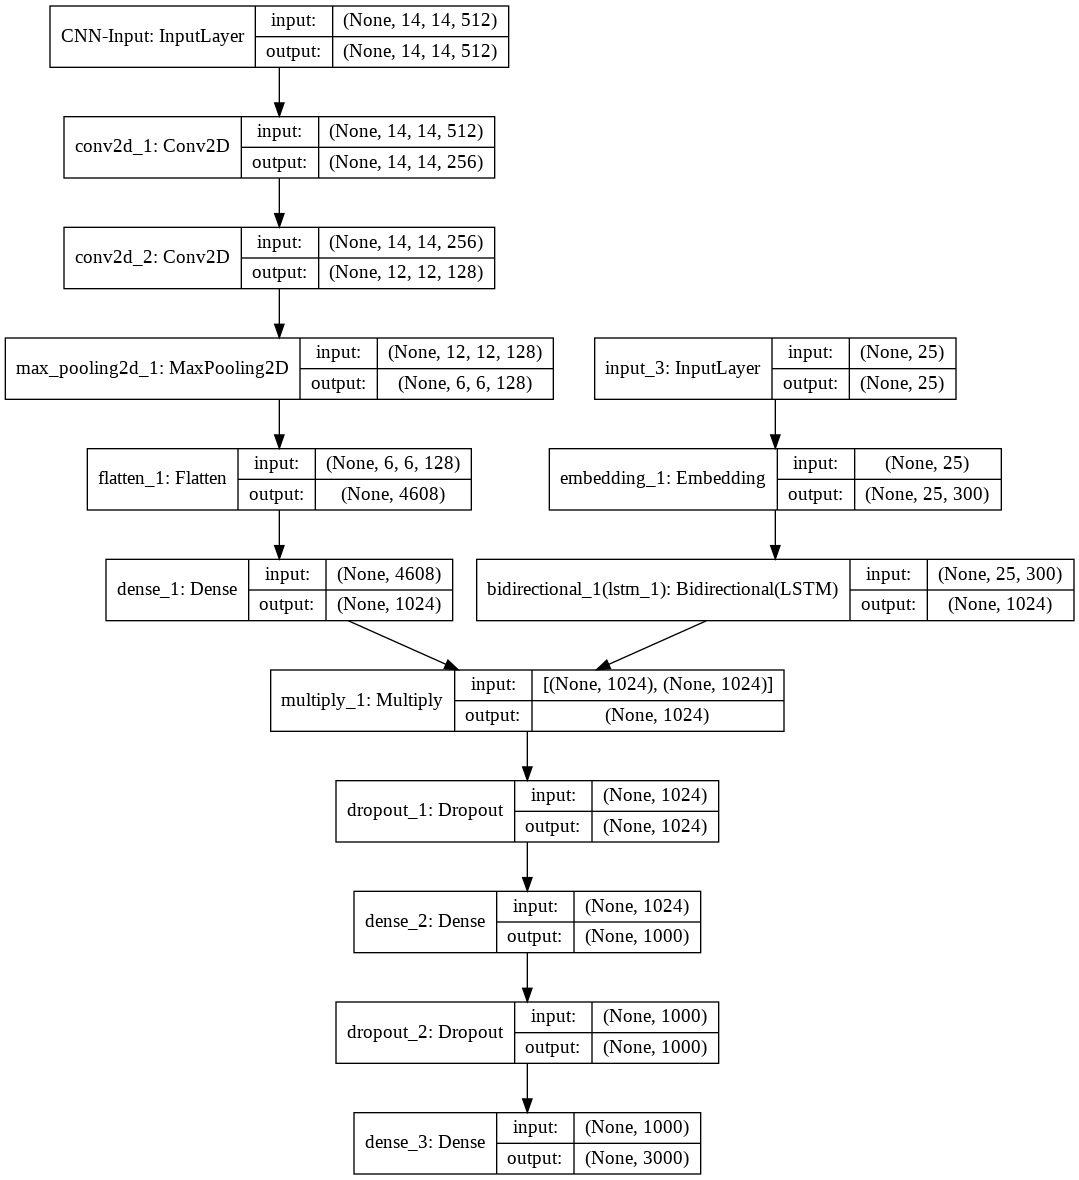

In [45]:
from keras.utils import plot_model

plot_model(question_answering,show_layer_names=True,show_shapes=True, to_file='./models/question_answering_model.png')

In [12]:
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = question_answering.fit([train_visual_features,train_questions],
                    to_categorical(train_answers,num_classes=3000),
                    batch_size=32,
                    epochs=50,
                    validation_split=0.12,
                    callbacks= [es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 5968 samples, validate on 814 samples
Epoch 1/50
5968/5968 [==============================] - 39s 6ms/step - loss: 5.1230 - acc: 0.0952 - val_loss: 4.6826 - val_acc: 0.1769
Epoch 2/50
5968/5968 [==============================] - 33s 5ms/step - loss: 4.1142 - acc: 0.1503 - val_loss: 4.4283 - val_acc: 0.1855
Epoch 3/50
5968/5968 [==============================] - 33s 5ms/step - loss: 3.7985 - acc: 0.1796 - val_loss: 4.3592 - val_acc: 0.1843
Epoch 4/50
5968/5968 [==============================] - 33s 5ms/step - loss: 3.6125 - acc: 0.1868 - val_loss: 4.2937 - val_acc: 0.1953
Epoch 5/50
5968/5968 [==============================] - 33s 5ms/step - loss: 3.4077 - acc: 0.2203 - val_loss: 4.3415 - val_acc: 0.2187
Epoch 6/50
5968/5968 [==============================] - 33s 5ms/step - loss: 3.2274 - acc: 0.2361 - val_loss: 4.4009 - val_acc: 0.1880
Epoch 7/50
5968/5968 [=========================

### Visualize loss

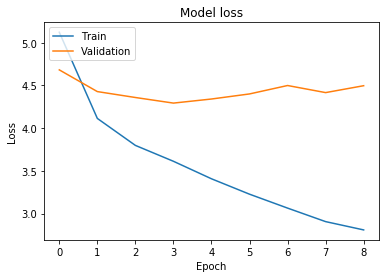

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Visualize accuracy

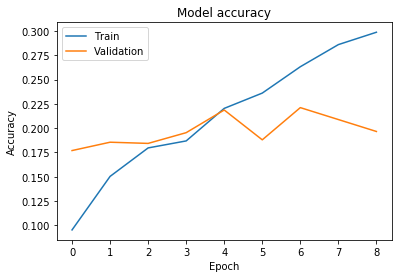

In [31]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Save model

In [0]:
question_answering.save_weights('./models/question_answering_model2.h5')

### Make predictions

Reload the environment before loading the test data as there is not enough RAM to sustain both training and test data

In [0]:
import pickle
from collections import deque
import numpy as np

file_name='./data/processed_data/questions-visual_features-test.txt'

with open(file_name, 'rb') as pickleFile:
  test_deque=pickle.load(pickleFile)

test_questions, test_images, test_answers = zip(*test_deque)

### CONVERT FROM TUPLE TO ARRAY
test_questions=np.array(test_questions)
test_visual_features=np.array(test_images)
test_answers=np.array(test_answers)

Reload the model if session was restarted

In [0]:
question_answering.load_weights('./models/question_answering_model2.h5')

In [0]:
#make predicitons on the test set
predictions=question_answering.predict([test_visual_features,test_questions])
#use argmax to get the index with the highest probability
predictions_argmax=np.argmax(predictions, axis=1)

In [0]:
import numpy as np

reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
reverse_word_map[0]='not in vocab'

predicted_answers=[]
real_answers=[]

for word in predictions_argmax:
  predicted_answers.append(reverse_word_map[word])
for word in np.squeeze(test_answers):
  real_answers.append(reverse_word_map[word])

In [0]:
for i in range(len(predicted_answers)):
  print('real :' + real_answers[i])
  print('pred :'+ predicted_answers[i])
  print('')

## Evaluate Results

#### Accuracy

In [0]:
### accuracy on test set
correct=0

for i in range(len(predicted_answers)):
  if predicted_answers[i]==real_answers[i]:
    correct+=1

accuracy=correct/len(predicted_answers)
print('accuracy :' + str(accuracy))

accuracy :0.21871138570167697


Another way to evaluate your model is to calculate the WUPS score. In NLP tasks this might be more relevant as the accuracy does not account for words that are similar or close in meaning. For example predicting 'box' when its 'carton' would be considered wrong using the accuracy, but they are really close. WUPS checks for words that are close. The highest the WUPS, the closer two words are between them.